# Reference
@董峦老师

@Tommy Huang 矩陣分解(Matrix Factorization): 交替最小平方法(Alternating least squares, ALS)和加權交替最小平方法(Alternating-least-squares with weighted-λ -regularization, ALS-WR)https://chih-sheng-huang821.medium.com/%E7%9F%A9%E9%99%A3%E5%88%86%E8%A7%A3-matrix-factorization-%E4%BA%A4%E6%9B%BF%E6%9C%80%E5%B0%8F%E5%B9%B3%E6%96%B9%E6%B3%95-alternating-least-squares-2a71fd1393f7

@yeomko22 ALS_implementation https://github.com/yeomko22/ALS_implementation

@ GRNovmbrain & bijingrui 矩阵求导 https://blog.csdn.net/bijingrui/article/details/107804220

@Ron Zacharski Yourtion 推荐系统入门 https://www.bookstack.cn/read/DataminingGuideBook/chapter-2-chapter-2-3.md

@标点符 机器学习之距离与相似度计算 https://www.biaodianfu.com/distance.html

@吴恩达机器学习系列课程 https://www.bilibili.com/video/BV164411b7dx?p=96

@ming_tian0826 基于矩阵分解的协同过滤算法 https://www.cnblogs.com/wyb-mingtian/p/12315551.html

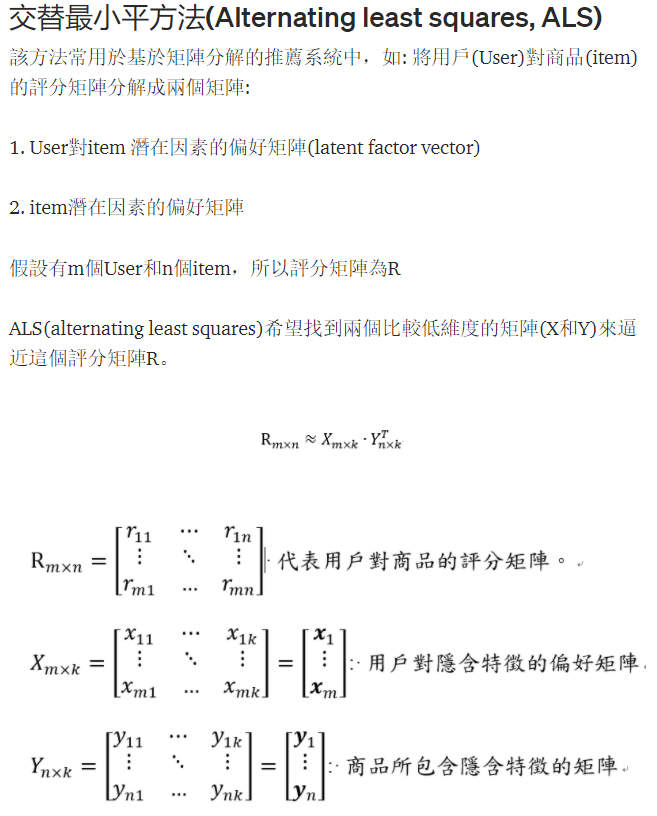

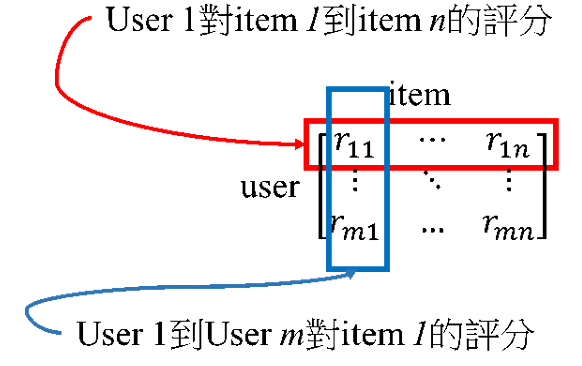

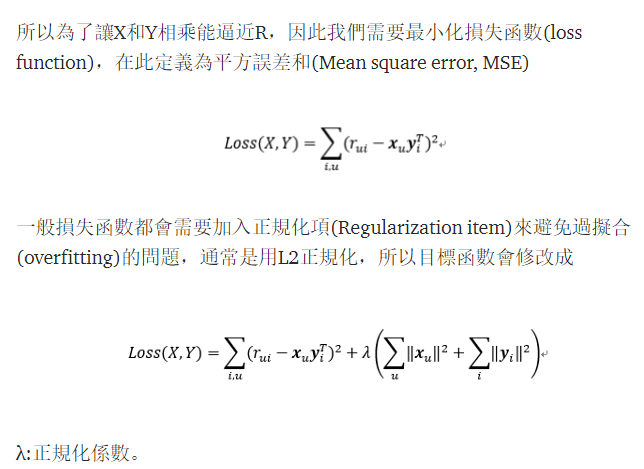

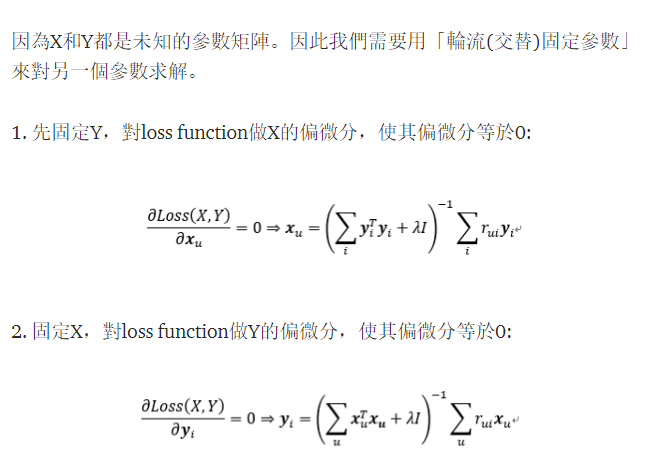

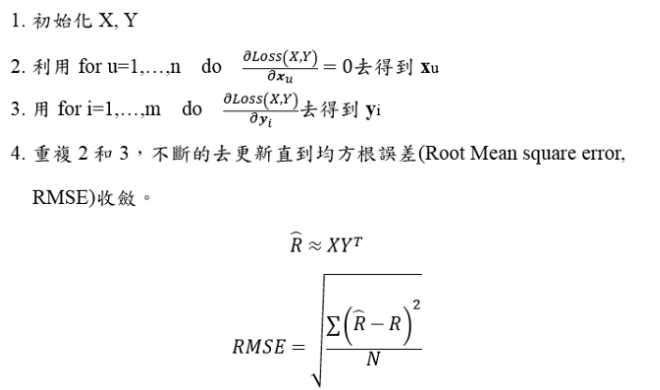

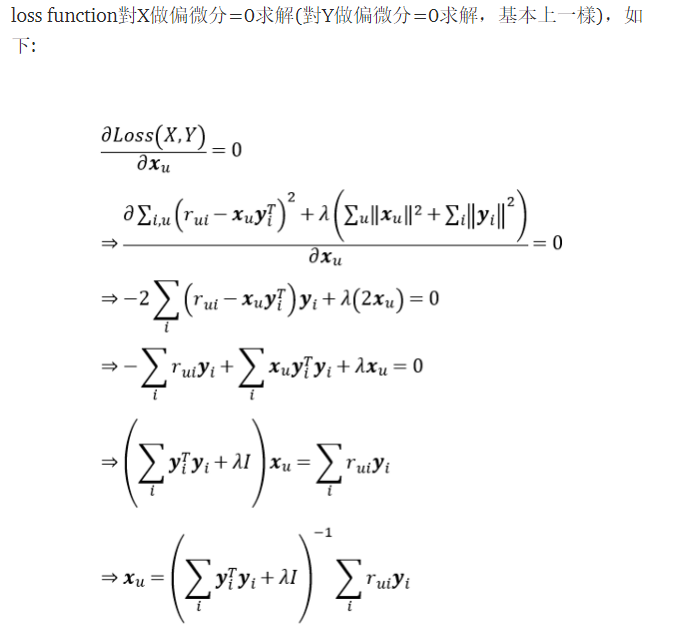

${\bf A} \in {\Bbb R}^ {n \times n} $， ${\bf x } \in { \Bbb R}^{n \times n} $

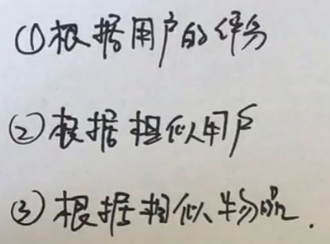

在很多情況下用戶沒有明顯反饋對商品的偏好，我們只能通過用戶的行為來推斷他對商品的偏好。例如，在節目推薦的問題中，對節目的收看的次數或是時間，可以推斷次數越高時間越長，用戶對此偏好程度越高，但對於沒有收看的節目來說，可能用戶不知道有此節目，或是沒有途徑取得該節目，我們不能確定的推測是用戶不喜歡該節目。  
ALS-WR通過置信度權重來解決此問題，對於確信用戶偏好的項目賦予較大的權重，對於沒有反饋的項目，給予較小的權重。

# Initialize parameters

- r_lambda: normalization parameter  
- alpha: confidence level  
- nf: dimension of latent vector of each user and item  
- initilzed values(40, 200, 40) are the best parameters from the paper

In [1]:
r_lambda = 40
nf = 200
alpha = 40

### Initialize original rating matrix data
- make sample (10 x 11) matrix
- 10 : num of users
- 11 : num of items

In [2]:
import numpy as np


# sample rating matrix
R = np.array([[0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0],
              [0, 3, 4, 0, 3, 0, 0, 2, 2, 0, 0],
              [0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
              [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5],
              [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4],
              [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
              [0, 0, 0, 3, 0, 0, 0, 0, 4, 5, 0]])
print(R.shape)

(10, 11)


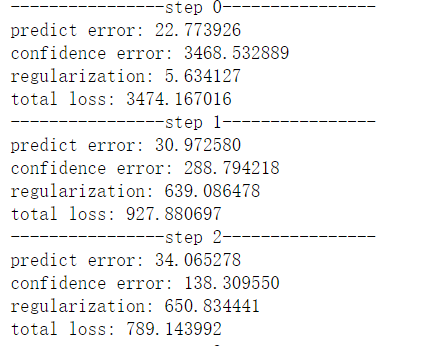

In [3]:
# import os
# moviecount = 9125
# usercount = 671
# datapath = 'ml-latest-small'

# moviepath = os.path.join(datapath, 'movies.csv')
# fh = open(moviepath, 'r')
# lines = fh.readlines()[1:] # 排除标题行

# column_movie_dict = {}
# movie_column_dict = {}
# for i in range(moviecount):#0~9124
#     items = lines[i].split(',', maxsplit=1)
#     column_movie_dict[i] = [int(items[0]), items[1].strip()]# 去除首尾空格
#     movie_column_dict[int(items[0])] = i
# """**delimiter: the str used to separate data. 横纵坐标以 ',' 分割，因此给 delimiter 传入 ','。
# skip_header: ** the number of lines to skip at the beginning of the file. 有用数据是从1行开始的，
# 因此给 skip_header 传入 1。"""
# ratingpath = os.path.join(datapath, 'ratings.csv')
# ratings_raw = np.genfromtxt(ratingpath, delimiter=',', skip_header=1)
# ratings = np.empty((usercount, moviecount), dtype=np.float64)
# mask = np.zeros_like(ratings)
# for r in ratings_raw:
#     ratings[int(r[0]-1), int(movie_column_dict[r[1]])] = r[2]
#     mask[int(r[0]-1), int(movie_column_dict[r[1]])] = 1
# R = ratings

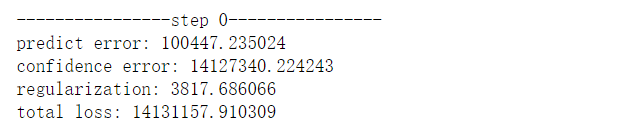

### Initialize user and item latent factor matrix
- nu: num of users (10)
- ni: num of items (11)
- nf: dimension of latent vector

In [4]:
nu = R.shape[0]
ni = R.shape[1]

# initialize X and Y with very small values
X = np.random.rand(nu, nf) * 0.01
Y = np.random.rand(ni, nf) * 0.01

print(X)

[[0.00407192 0.00625841 0.00566089 ... 0.00792813 0.00479698 0.00025955]
 [0.00908225 0.00235812 0.0030881  ... 0.00807829 0.00897312 0.00420793]
 [0.00089571 0.00982683 0.0054068  ... 0.00431244 0.00563805 0.00566539]
 ...
 [0.00865744 0.0094403  0.0067698  ... 0.00129951 0.0045335  0.00404722]
 [0.00537829 0.00520594 0.0049544  ... 0.00448416 0.00878182 0.00473264]
 [0.00542627 0.00598398 0.00164317 ... 0.00152694 0.00550685 0.00947583]]


### Initialize Binary Rating Matrix P
- Convert original rating matrix R into P
- Pui = 1 if Rui > 0
- Pui = 0 if Rui = 0

In [5]:
P = np.copy(R)
P[P > 0] = 1
print(P)
print(P.shape)

[[0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 1 1 0 1 0 0 1 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 1 0 0 0 0 1 1 0]]
(10, 11)


### Initialize Confidence Matrix C
- Cui = 1 + alpha * Rui
- Cui means confidence level of certain rating data

In [6]:
C = 1 + alpha * R
print(C)

[[  1   1   1 161 161   1   1   1   1   1   1]
 [  1   1   1   1   1   1   1   1   1   1  41]
 [  1   1   1   1   1   1   1  41   1 161   1]
 [  1 121 161   1 121   1   1  81  81   1   1]
 [  1 201 201   1   1   1   1   1   1   1   1]
 [  1   1   1   1   1   1 201   1   1 201   1]
 [  1   1 161   1   1   1   1   1   1   1 201]
 [  1   1   1   1   1 161   1   1   1   1 161]
 [  1   1   1   1   1   1 201   1   1 201   1]
 [  1   1   1 121   1   1   1   1 161 201   1]]


### Set up loss function
- C: confidence matrix
- P: binary rating matrix
- X: user latent matrix
- Y: item latent matrix
- r_lambda: regularization lambda
- xTy: predict matrix  
  
- Total_loss = (confidence_level * predict loss) + regularization loss

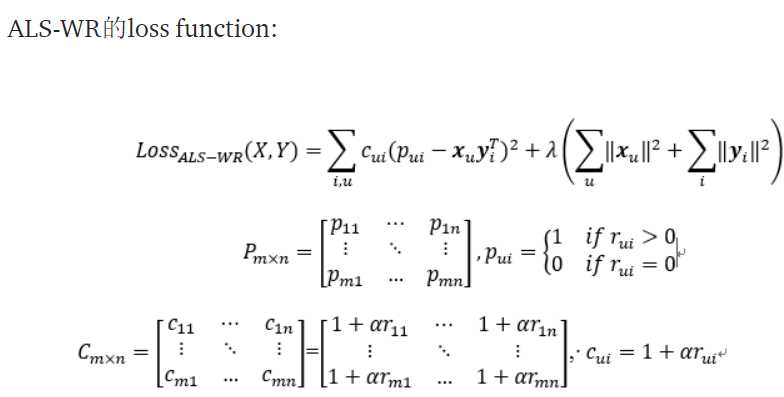

In [7]:
def loss_function(C, P, xTy, X, Y, r_lambda):
    predict_error = np.square(P - xTy)
    confidence_error = np.sum(C * predict_error) #*：矩阵点乘 @：矩阵乘法
    regularization = r_lambda * (np.sum(np.square(X)) + np.sum(np.square(Y)))
    total_loss = confidence_error + regularization
    return np.sum(predict_error), confidence_error, regularization, total_loss

### Optimization Function for user and item
- X[u] = (yTCuy + lambda*I)^-1yTCuPu
- Y[i] = (xTCix + lambda*I)^-1xTCiPy
- two formula is the same when it changes X to Y and u to i

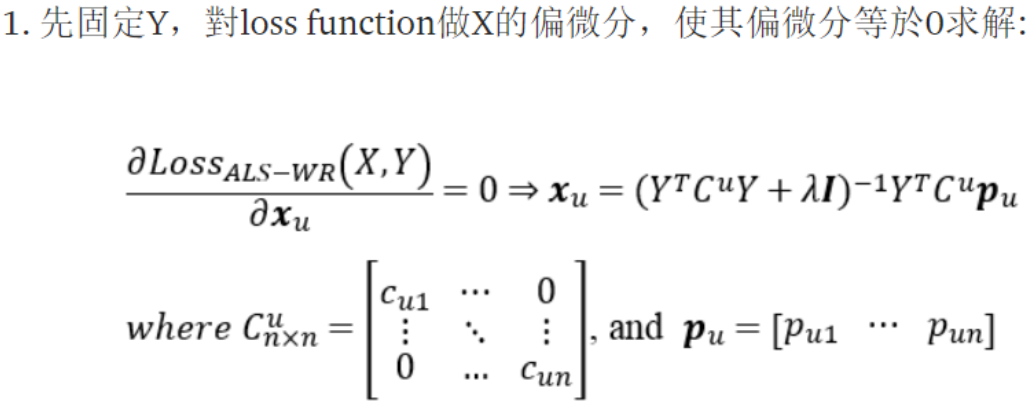

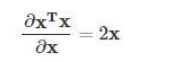

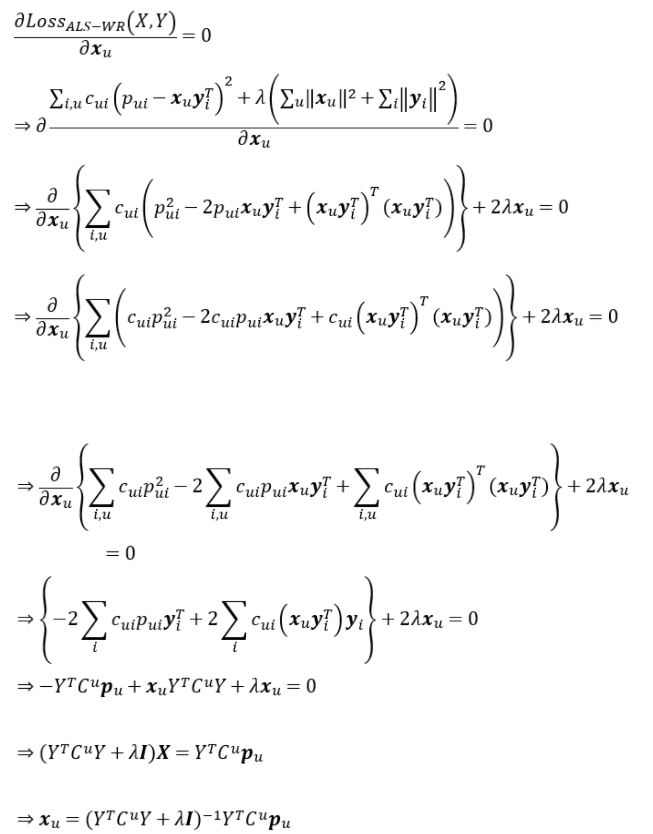

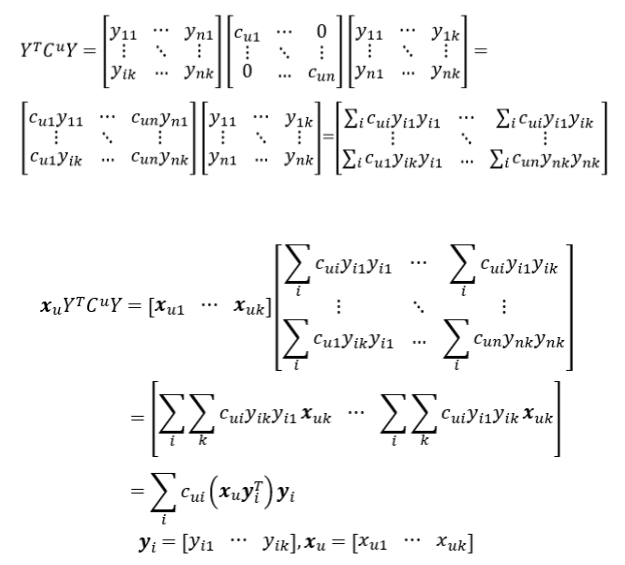

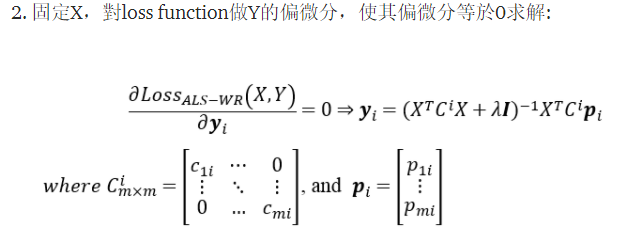

In [8]:
u=1
yT = np.transpose(Y)
Cu = np.diag(C[u]) 
yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P[u])
print('X[u].shape',X[:,u])

print(np.matmul(yT, Cu).shape)
print(P[u])
#P[u].shape
print(yT_Cu_pu.shape)
Cu = np.diag(C[u])
Cu = np.diag(C[u])
yT_Cu_y = np.matmul(np.matmul(yT, Cu), Y)
lI = np.dot(r_lambda, np.identity(nf))
yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P[u])
X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)
np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu).shape
type(np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu).shape)

X[u].shape [0.00625841 0.00235812 0.00982683 0.00118263 0.00312928 0.00554868
 0.00946443 0.0094403  0.00520594 0.00598398]
(200, 11)
[0 0 0 0 0 0 0 0 0 0 1]
(200,)


tuple

In [9]:
def optimize_user(X, Y, C, P, nu, nf, r_lambda):
    yT = np.transpose(Y)
    for u in range(nu):
        Cu = np.diag(C[u])
        yT_Cu_y = np.matmul(np.matmul(yT, Cu), Y)
        lI = np.dot(r_lambda, np.identity(nf))
        yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P[u])
        X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)

def optimize_item(X, Y, C, P, ni, nf, r_lambda):
    xT = np.transpose(X)
    for i in range(ni):
        Ci = np.diag(C[:, i])
        xT_Ci_x = np.matmul(np.matmul(xT, Ci), X)
        lI = np.dot(r_lambda, np.identity(nf))
        xT_Ci_pi = np.matmul(np.matmul(xT, Ci), P[:, i])
        Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)

In [10]:
import numpy as np
a=np.array([[1,2],[3,4]])
b=np.array([[1,1],[2,2]])
print("a:\n",a)
print("b:\n",b)
print("a*b:\n",a*b)
print("a@b\n",a@b)
print("np.sum(a):",np.sum(a))

a:
 [[1 2]
 [3 4]]
b:
 [[1 1]
 [2 2]]
a*b:
 [[1 2]
 [6 8]]
a@b
 [[ 5  5]
 [11 11]]
np.sum(a): 10


### Train
- usually ALS algorithm repeat train steps for 10 ~ 15 times

In [11]:
predict_errors = []
confidence_errors = []
regularization_list = []
total_losses = []

for i in range(15):
    if i!=0:   
        optimize_user(X, Y, C, P, nu, nf, r_lambda)
        optimize_item(X, Y, C, P, ni, nf, r_lambda)
    predict = np.matmul(X, np.transpose(Y))
    predict_error, confidence_error, regularization, total_loss = loss_function(C, P, predict, X, Y, r_lambda)
    
    predict_errors.append(predict_error)
    confidence_errors.append(confidence_error)
    regularization_list.append(regularization)
    total_losses.append(total_loss)
    
    print('----------------step %d----------------' % i)
    print("predict error: %f" % predict_error)
    print("confidence error: %f" % confidence_error)
    print("regularization: %f" % regularization)
    print("total loss: %f" % total_loss)
    
predict = np.matmul(X, np.transpose(Y))
print('final predict')
print([predict])

----------------step 0----------------
predict error: 22.773926
confidence error: 3468.532889
regularization: 5.634127
total loss: 3474.167016
----------------step 1----------------
predict error: 30.972580
confidence error: 288.794218
regularization: 639.086478
total loss: 927.880697
----------------step 2----------------
predict error: 34.065278
confidence error: 138.309550
regularization: 650.834441
total loss: 789.143992
----------------step 3----------------
predict error: 32.239136
confidence error: 120.185345
regularization: 650.703476
total loss: 770.888821
----------------step 4----------------
predict error: 29.731998
confidence error: 109.705020
regularization: 653.335816
total loss: 763.040836
----------------step 5----------------
predict error: 27.261286
confidence error: 102.672877
regularization: 656.244398
total loss: 758.917275
----------------step 6----------------
predict error: 25.169341
confidence error: 97.814192
regularization: 658.684555
total loss: 756.498747


<Figure size 432x288 with 0 Axes>

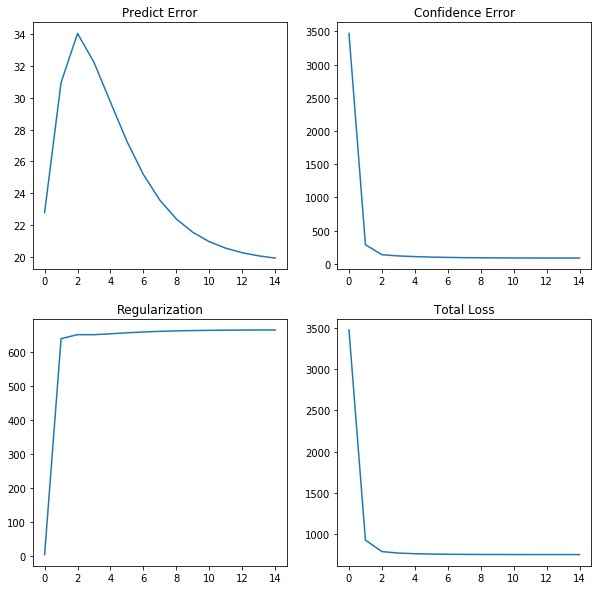

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.subplots_adjust(wspace=100.0, hspace=20.0)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
predict_error_line = fig.add_subplot(2, 2, 1)
confidence_error_line = fig.add_subplot(2, 2, 2)
regularization_error_line = fig.add_subplot(2, 2, 3)
total_loss_line = fig.add_subplot(2, 2, 4)

predict_error_line.set_title("Predict Error") 
predict_error_line.plot(predict_errors)

confidence_error_line.set_title("Confidence Error")
confidence_error_line.plot(confidence_errors)

regularization_error_line.set_title("Regularization")
regularization_error_line.plot(regularization_list)

total_loss_line.set_title("Total Loss")
total_loss_line.plot(total_losses)
plt.show()